# Constructing an Interaction Prior based on Receptor-Ligand Gene Expression

In [1]:
import numpy as np
import pandas as pd
import pickle5 as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import omnipath
from tqdm import tqdm_notebook
import scanpy as sc

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Load gene expression data

In [2]:
hours_post_coculture = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
hours_post_coculture = {i: hour for i, hour in enumerate(hours_post_coculture)}
cell_types_to_cluster_numbers = {
    'Other CD8+ T cells': [19,28],
    'MEC1 cells': [1,7,8,10,16,17,22,23,24],
    'Activated T cells': [3,12,14],
    'Exhausted T cells': [0,6,9,11,15,21,26]
}
cluster_numbers_to_cell_types = {cluster_number: cell_type 
                                 for cell_type, cluster_numbers in cell_types_to_cluster_numbers.items()
                                 for cluster_number in cluster_numbers}

gene_exp_df = pickle.load(open('data/CAR-T ratios and umap/data_df_revised_clusters.pkl', 'rb'))
# Filter to experiment C
gene_exp_df = gene_exp_df[gene_exp_df.index.str.startswith('CARC')]
gene_exp_df = gene_exp_df[gene_exp_df['cluster_number'].isin(cluster_numbers_to_cell_types.keys())]
gene_exp_df['cell_type'] = gene_exp_df['cluster_number'].replace(cluster_numbers_to_cell_types)
gene_exp_df['timestamp'] = [int(index_split[1][1]) 
                       for index_split in gene_exp_df.index.str.split('_')]
gene_exp_df['timestamp'] = gene_exp_df['timestamp'].replace(hours_post_coculture)
genes = gene_exp_df.columns[:-3]
gene_exp_df

,MIR1302-2HG,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,SAMD11,NOC2L,...,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC233755.1,AC240274.1,cluster_number,cell_type,timestamp
CARC_T8_AAACCTGAGAAGGCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,Activated T cells,12.50
CARC_T9_AAACCTGAGACAAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,20.50
CARC_T6_AAACCTGAGACAATAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,4.00
CARC_T9_AAACCTGAGCCATCGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.633307,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,MEC1 cells,20.50
CARC_T2_AAACCTGAGGTAGCTG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.990700,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,20.50
CARC_T9_TTTGTCATCGACGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.445403,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,Exhausted T cells,20.50
CARC_T9_TTTGTCATCGGCTTGG,-2.302585,-2.302585,-2.302585,-2.302585,-0.744831,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,Exhausted T cells,20.50
CARC_T7_TTTGTCATCGTGGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9,Exhausted T cells,8.50


Filter genes with low expression

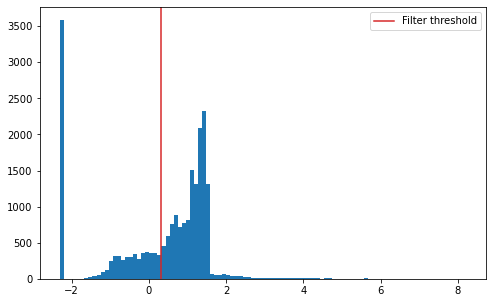

In [7]:
threshold = 0.3

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df[genes].max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [8]:
print("Percent genes removed:", (gene_exp_df[genes].max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df[genes].max() <= threshold)
genes = genes[~gene_filter]
gene_exp_df = gene_exp_df.drop(columns=gene_filter[gene_filter].index)
gene_exp_df

Percent genes removed: 35.8975509105589


,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,PERM1,ISG15,AGRN,C1orf159,...,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,cluster_number,cell_type,timestamp
CARC_T8_AAACCTGAGAAGGCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,0.202868,3.453078,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,Activated T cells,12.50
CARC_T9_AAACCTGAGACAAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,3.312464,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,20.50
CARC_T6_AAACCTGAGACAATAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.117269,-2.302585,-2.302585,...,-0.490678,2.670134,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,4.00
CARC_T9_AAACCTGAGCCATCGC,-2.302585,-2.302585,-2.302585,-0.633307,-2.302585,-2.302585,-2.302585,-0.039088,-2.302585,-2.302585,...,-0.039088,3.094332,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,MEC1 cells,20.50
CARC_T2_AAACCTGAGGTAGCTG,-2.302585,-2.302585,-2.302585,-0.990700,-2.302585,-2.302585,-2.302585,0.169968,-2.302585,-2.302585,...,-0.442180,3.253281,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.648138,-2.302585,-2.302585,...,-2.302585,3.882065,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,20.50
CARC_T9_TTTGTCATCGACGGAA,-2.302585,-2.302585,-2.302585,-0.445403,-2.302585,-2.302585,-2.302585,-0.445403,-2.302585,-2.302585,...,-0.093378,3.040313,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,Exhausted T cells,20.50
CARC_T9_TTTGTCATCGGCTTGG,-2.302585,-0.744831,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.744831,-2.302585,-2.302585,...,0.202486,3.150104,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,Exhausted T cells,20.50
CARC_T7_TTTGTCATCGTGGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,3.247368,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9,Exhausted T cells,8.50


Filter clusters by percent of cells in cluster

Clusters after filtering: ['Activated T cells', 'Exhausted T cells', 'MEC1 cells', 'Other CD8+ T cells']


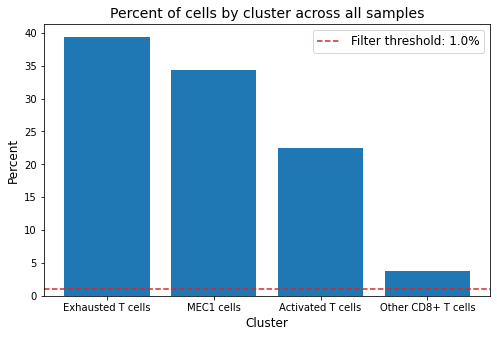

In [13]:
threshold = 0.01
cluster_counts = gene_exp_df['cell_type'].value_counts(normalize=True)

plt.figure(figsize=(8, 5))
plt.bar(range(len(cluster_counts)), cluster_counts.values * 100)
plt.axhline(threshold*100, color='tab:red', linestyle='--', 
            label=f'Filter threshold: {threshold * 100}%')
plt.xticks(range(len(cluster_counts)), cluster_counts.index)
plt.title('Percent of cells by cluster across all samples', fontsize=14)
plt.ylabel('Percent', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.legend(fontsize=12, loc='upper right')

clusters_of_interest = sorted(cluster_counts[cluster_counts >= threshold].index)
print('Clusters after filtering:', list(clusters_of_interest))

In [14]:
len(clusters_of_interest)

4

Load receptor-ligand pairs from Omnipath DB

In [15]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
0,P0DP23,Q13507,CALM1,TRPC3,True,False,True,True,False,True,6,CellTalkDB:11248050;HPRD:15104175;TRIP:1124805...,CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;LRdb;TR...,11248050;11290752;12601176;15104175;18215135,5,7,5
1,P60903,Q9H1D0,S100A10,TRPV6,True,True,False,True,True,False,5,CellTalkDB:18187190;HPRD:12660155;TRIP:1266015...,CellTalkDB;HPRD;TRIP,12660155;16189514;18187190,3,3,3
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
3,P46531,Q9Y219,NOTCH1,JAG2,True,False,True,False,False,False,3,HPRD:11006133;NetPath:11006133;SPIKE:15358736,Baccin2019;CellCall;HPRD;NetPath;Ramilowski201...,11006133;15358736,2,6,5
4,Q9Y219,P46531,JAG2,NOTCH1,True,True,True,True,True,False,19,Baccin2019:1100613311006130;CellChatDB:2235346...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,10958687;11006133;1100613311006130;16921404;18...,11,32,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,P18510,P01583,IL1RN,IL1A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
8346,P18510,P01584,IL1RN,IL1B,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
8347,P23467,COMPLEX:P05556_P08648,PTPRB,ITGA5_ITGB1,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1
8348,Q969E1,Q9UBU3,LEAP2,GHRL,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1


In [16]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])

# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
7,P05019,P08069,IGF1,IGF1R,True,True,False,True,True,False,27,Baccin2019:1852007;Baccin2019:2877871;CA1:8408...,Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...,11287679;12067807;14604834;185;1852007;1902995...,15,42,26
8,P46531,P78504,NOTCH1,JAG1,True,True,False,False,False,False,16,Baccin2019:11006133;BioGRID:11006133;DIP:18660...,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntA...,11006133;16713569;17537801;18495817;18660822;2...,9,14,13
9,P78504,P46531,JAG1,NOTCH1,True,True,True,True,True,False,36,ACSN:22330899;ACSN:22363130;Baccin2019:7697721...,ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...,10958687;11;11006133;15137944;16713569;1692140...,20,39,27
15,Q9GZX6,Q08334,IL22,IL10RB,True,True,False,True,True,False,12,CellTalkDB:10875937;HPRD:10875937;LRdb:1087593...,CellCall;CellTalkDB;Fantom5_LRdb;Guide2Pharma;...,10875937;12513909;15120653;17208301;18509351;2...,6,20,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,Q01974,Q9NPG1,ROR2,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8297,P34925,Q9NPG1,RYK,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8304,Q01974,O60353,ROR2,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8305,P34925,O60353,RYK,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1


Identify DEGs per sample, per cluster

In [37]:
timestamp = 8.5
clusters_of_interest = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']

sample_gene_exp_df = gene_exp_df[(gene_exp_df['timestamp'] == timestamp) & 
                                 (gene_exp_df['cell_type'].isin(clusters_of_interest))]
clusters_with_more_than_1_cell = sample_gene_exp_df['cell_type'].value_counts()\
                                    [sample_gene_exp_df['cell_type'].value_counts() > 1].index
sample_gene_exp_df = sample_gene_exp_df[sample_gene_exp_df['cell_type'].\
                        isin(clusters_with_more_than_1_cell)]
sample_adata = sc.AnnData(sample_gene_exp_df[genes], 
                          obs=sample_gene_exp_df[['cell_type']].astype('str'))
sample_adata

AnnData object with n_obs × n_vars = 2012 × 14291
    obs: 'cell_type'

In [38]:
sc.tl.rank_genes_groups(sample_adata, groupby='cell_type', method='wilcoxon', key_added='wilcoxon')
sample_adata

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


AnnData object with n_obs × n_vars = 2012 × 14291
    obs: 'cell_type'
    uns: 'wilcoxon'

In [41]:
sample_cluster_deg_df = sc.get.rank_genes_groups_df(sample_adata, group="Exhausted T cells", key='wilcoxon')
top_degs = sample_cluster_deg_df[(sample_cluster_deg_df['pvals_adj'] <= 0.01) & 
                                 (sample_cluster_deg_df['scores'] >= 0)]
top_degs.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,EIF5A,38.462948,2.590170,0.000000e+00,0.000000e+00
1,RBM8A,38.005520,2.257939,0.000000e+00,0.000000e+00
2,FABP5,37.891048,3.379535,0.000000e+00,0.000000e+00
3,RPL36AL,37.736897,0.958357,0.000000e+00,0.000000e+00
4,NDFIP1,37.723465,NaN,0.000000e+00,0.000000e+00
5,PSMB1,37.641304,1.503449,4.539879e-310,1.081323e-306
6,TIMM8B,37.613789,NaN,1.279357e-309,2.611898e-306
7,REXO2,37.527252,NaN,3.310979e-308,5.914649e-305
8,CD2,37.465664,NaN,3.339310e-307,5.302453e-304
9,C1QBP,37.458832,2.318696,4.313890e-307,6.164980e-304


Text(0.5, 1.0, 'Distribution of TIGIT at time 8.5')

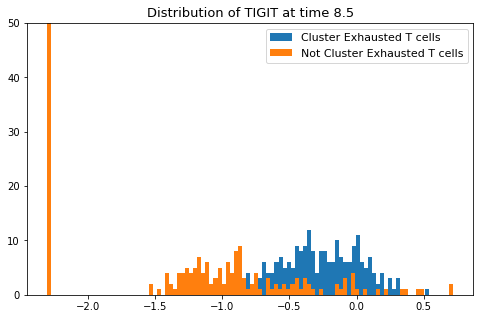

In [50]:
timestamp = 8.5
cluster = 'Exhausted T cells'
gene = 'TIGIT'

sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
sample_gene_exp_in_cluster = sample_gene_exp_df.loc[sample_gene_exp_df['cell_type'] == cluster, gene]
sample_gene_exp_out_of_cluster = sample_gene_exp_df.loc[sample_gene_exp_df['cell_type'] != cluster, gene]
plt.figure(figsize=(8, 5))
plt.hist(sample_gene_exp_in_cluster, bins=100, label=f'Cluster {cluster}')
plt.hist(sample_gene_exp_out_of_cluster, bins=100, label=f'Not Cluster {cluster}')
plt.ylim([0, 50])
plt.legend(fontsize=11)
plt.title(f'Distribution of {gene} at time {timestamp}', fontsize=13)

Identify DEGs per sample, per cluster, for all samples and clusters

In [51]:
sample_to_cluster_to_degs = dict()

for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):
    print(timestamp)
    sample_to_cluster_to_degs[timestamp] = dict()
    sample_gene_exp_df = gene_exp_df[(gene_exp_df['timestamp'] == timestamp) & 
                                     (gene_exp_df['cell_type'].isin(clusters_of_interest))]
    clusters_with_more_than_1_cell = sample_gene_exp_df['cell_type'].value_counts()\
                                        [sample_gene_exp_df['cell_type'].value_counts() > 1].index
    sample_gene_exp_df = sample_gene_exp_df[sample_gene_exp_df['cell_type'].isin(clusters_with_more_than_1_cell)]
    if sample_gene_exp_df.shape[0] == 0: continue
    sample_adata = sc.AnnData(sample_gene_exp_df[genes], 
                              obs=sample_gene_exp_df[['cell_type']].astype('str'))
    sc.tl.rank_genes_groups(sample_adata, groupby='cell_type', method='wilcoxon', key_added='wilcoxon')
    for cluster in clusters_of_interest:
        if cluster not in clusters_with_more_than_1_cell: 
            sample_to_cluster_to_degs[timestamp][cluster] = []
            continue
        sample_cluster_deg_df = sc.get.rank_genes_groups_df(sample_adata, group=str(cluster), key='wilcoxon')
        top_degs = sample_cluster_deg_df[(sample_cluster_deg_df['pvals_adj'] <= 0.01) & 
                                         (sample_cluster_deg_df['scores'] >= 0)]
        sample_to_cluster_to_degs[timestamp][cluster] = list(zip(top_degs['names'], top_degs['scores']))

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_90358/803265464.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):


  0%|          | 0/10 [00:00<?, ?it/s]

12.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


20.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


4.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.25
2.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


8.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


1.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.5
0.08333333333333333
0.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shouvik

Summary of highest-scoring DEGs across all samples, by cluster

In [52]:
cluster_deg_counts = {cluster: {} for cluster in clusters_of_interest}

for sample, cluster_degs in sample_to_cluster_to_degs.items():
    for cluster, degs in cluster_degs.items():
        for gene, score in degs:
            if gene in cluster_deg_counts[cluster]:
                cluster_deg_counts[cluster][gene] += score
            else:
                cluster_deg_counts[cluster][gene] = score
                
top_cluster_degs = pd.DataFrame()
for cluster in clusters_of_interest:
    degs_sorted_by_freq = pd.DataFrame(cluster_deg_counts[cluster].items()).sort_values(1, ascending=False)
    top_cluster_degs[cluster] = degs_sorted_by_freq.iloc[:25, 0].values
    
top_cluster_degs

,MEC1 cells,Other CD8+ T cells,Activated T cells,Exhausted T cells
0,IGKV4-1,TMSB10,FXYD5,EIF5A
1,HLA-DRA,PFN1,TPT1,PSMB1
2,HLA-DQA1,CORO1A,CD52,EID1
3,IGHM,MYL6,GSTK1,FABP5
4,MZB1,S100A11,ITM2B,PSMB6
5,NCF1,CALM1,IFITM2,IL2RA
6,HLA-DPA1,S100A10,RARRES3,SLC25A3
7,MT-ND2,GZMA,GMFG,ZNF706
8,HLA-DRB5,RAC2,EIF3F,RBM8A
9,HLA-DRB1,S100A6,AES,GTF3C6


Create interaction score prior matrix for one sample

In [53]:
timestamp = 8.5
sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
sample_gene_exp_df

,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,PERM1,ISG15,AGRN,C1orf159,...,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,cluster_number,cell_type,timestamp
CARC_T7_AAACCTGCAATGGTCT,-2.302585,-2.302585,-2.302585,0.042249,-2.302585,-2.302585,-2.302585,0.415238,-2.302585,-2.302585,...,0.899301,4.003744,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,8.5
CARC_T7_AAACCTGCAATTGCTG,-2.302585,-2.302585,-2.302585,-0.368449,-2.302585,-2.302585,-2.302585,-0.117573,-2.302585,-2.302585,...,0.249679,3.343196,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,8.5
CARC_T7_AAACCTGTCCGAAGAG,-2.302585,-2.302585,-2.302585,-0.718386,-2.302585,-2.302585,-2.302585,0.233185,-2.302585,-2.302585,...,-0.718386,3.359606,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,8.5
CARC_T7_AAACCTGTCGGAGGTA,-2.302585,-2.302585,-2.302585,-0.781259,-2.302585,-2.302585,-2.302585,-0.203760,-2.302585,-2.302585,...,-0.005442,3.166180,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,23,MEC1 cells,8.5
CARC_T7_AAACCTGTCGGCATCG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,0.782820,3.378504,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T7_TTTGTCAGTCATACTG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.148828,-2.302585,-2.302585,...,-2.302585,2.704486,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,8.5
CARC_T7_TTTGTCAGTCGCATCG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.072729,3.344043,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,22,MEC1 cells,8.5
CARC_T7_TTTGTCAGTGGGTATG,-2.302585,-2.302585,-2.302585,0.585381,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,0.585381,3.364758,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9,Exhausted T cells,8.5
CARC_T7_TTTGTCATCAGCAACT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,0.119712,3.208912,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9,Exhausted T cells,8.5


In [54]:
sample_cluster_avg_gene_exp = sample_gene_exp_df.groupby('cell_type').mean()[genes]
sample_cluster_avg_gene_exp

,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,PERM1,ISG15,AGRN,C1orf159,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1
cell_type,,,,,,,,,,,,,,,,,,,,,
Activated T cells,-2.302585,-2.302585,-2.302585,-1.946886,-2.302585,-2.302585,-2.302585,0.182194,-2.276758,-2.290807,...,1.135295,1.598323,1.094722,-0.912434,3.249939,-2.302585,-2.302585,-2.265696,-2.302585,-2.302585
Exhausted T cells,-2.296419,-2.254782,-2.300799,-1.325041,-2.301012,-2.292743,-2.302585,-0.262306,-2.293877,-2.279432,...,1.369492,1.580489,1.880620,-0.606064,2.999147,-2.296053,-2.299119,-2.296727,-2.294338,-2.300922
MEC1 cells,-2.278041,-2.243915,-2.301009,-0.764842,-2.280515,-2.298237,-2.302585,0.015189,-2.246751,-2.248215,...,1.876839,2.581490,2.371850,0.017751,3.376621,-2.298021,-2.302585,-2.299638,-2.297608,-2.300936
Other CD8+ T cells,-2.302585,-2.302585,-2.302585,-1.942828,-2.302585,-2.302585,-2.302585,0.768558,-2.302585,-2.302585,...,1.070512,1.454892,1.248850,-0.849705,3.137740,-2.302585,-2.276510,-2.302585,-2.302585,-2.302585


In [60]:
cluster_interaction_score_matrix = np.full((len(clusters_of_interest), len(clusters_of_interest)), 
                                           np.nan)

clusters_rl_gene_exp = []
for row, receiver_cluster in enumerate(clusters_of_interest):
    for col, sender_cluster in enumerate(clusters_of_interest):
        if (receiver_cluster in sample_cluster_avg_gene_exp.index and 
            sender_cluster in sample_cluster_avg_gene_exp.index):
            ligand_gene_expressions = sample_cluster_avg_gene_exp.loc[sender_cluster][rl_pairs['source_genesymbol']]
            receptor_gene_expressions = sample_cluster_avg_gene_exp.loc[receiver_cluster][rl_pairs['target_genesymbol']]
            # Filter down to highly co-expressed and differentially-expressed RL pairs
            sample_sender_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][sender_cluster]]
            sample_receiver_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][receiver_cluster]]
            rl_interaction_thresholded = \
                (ligand_gene_expressions.index.isin(sample_sender_cluster_degs) & 
                 receptor_gene_expressions.index.isin(sample_receiver_cluster_degs))
            for i in np.where(rl_interaction_thresholded)[0]:
                clusters_rl_gene_exp.append({
                    'Source cluster': sender_cluster,
                    'Ligand': ligand_gene_expressions.index[i],
                    'Ligand expression': ligand_gene_expressions[i],
                    'Target cluster': receiver_cluster,
                    'Receptor': receptor_gene_expressions.index[i],
                    'Receptor expression': receptor_gene_expressions[i],
                    'Ligand + Receptor expression': ligand_gene_expressions[i] + receptor_gene_expressions[i]
                })
            cluster_interaction_score_matrix[row][col] = rl_interaction_thresholded.sum()

Text(0.5, 1.02, 'Cluster interaction scores (time 8.5)')

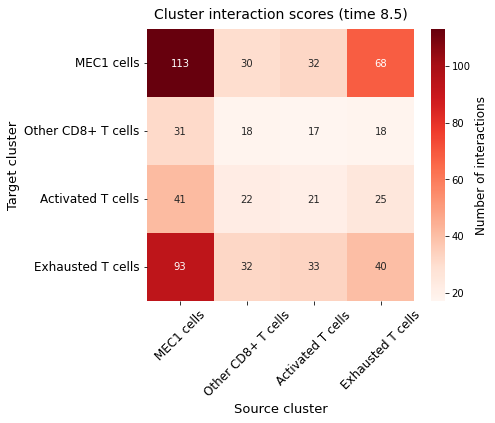

In [73]:
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cluster_interaction_score_matrix, cmap="Reds", annot=True, fmt='.0f', 
                 cbar_kws={'label': 'Number of interactions'})
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_of_interest, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Cluster interaction scores (time {timestamp})', fontsize=14, y=1.02)

In [75]:
def create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, rl_pairs, clusters_of_interest, 
                                             sample_to_cluster_to_degs):
    sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
    sample_cluster_avg_gene_exp = sample_gene_exp_df.groupby('cell_type').mean()
    cluster_interaction_score_matrix = np.full((len(clusters_of_interest), len(clusters_of_interest)), 
                                               np.nan)
    for row, receiver_cluster in enumerate(clusters_of_interest):
        for col, sender_cluster in enumerate(clusters_of_interest):
            if (receiver_cluster in sample_cluster_avg_gene_exp.index and 
                sender_cluster in sample_cluster_avg_gene_exp.index):
                ligand_gene_expressions = sample_cluster_avg_gene_exp.loc[sender_cluster][rl_pairs['source_genesymbol']]
                receptor_gene_expressions = sample_cluster_avg_gene_exp.loc[receiver_cluster][rl_pairs['target_genesymbol']]
                # Filter down to highly co-expressed and differentially-expressed RL pairs
                sample_sender_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][sender_cluster]]
                sample_receiver_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][receiver_cluster]]
                rl_interaction_thresholded = \
                    (ligand_gene_expressions.index.isin(sample_sender_cluster_degs) & 
                     receptor_gene_expressions.index.isin(sample_receiver_cluster_degs))
                cluster_interaction_score_matrix[row][col] = rl_interaction_thresholded.sum()
    return cluster_interaction_score_matrix

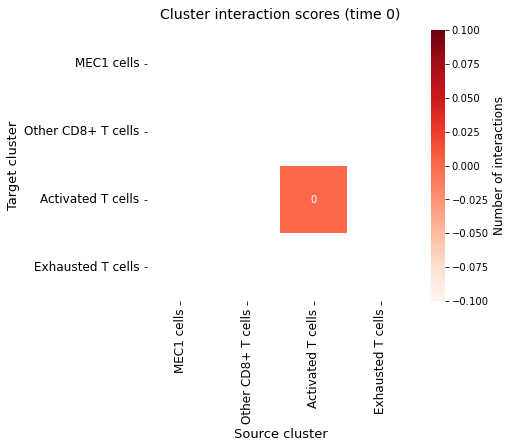

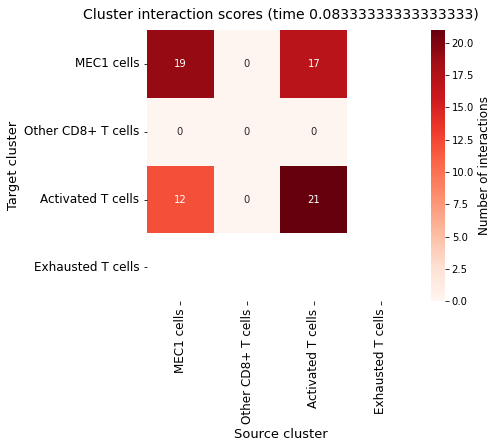

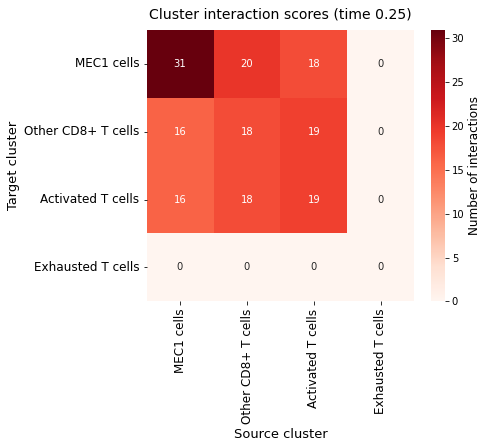

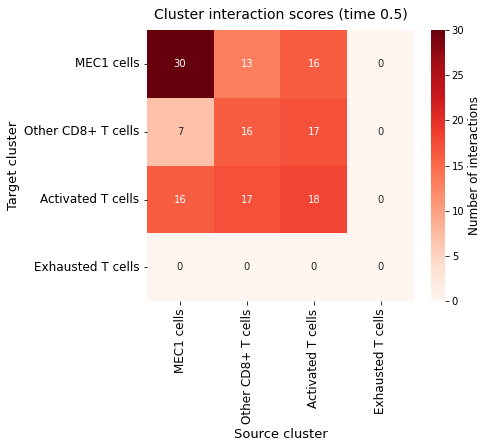

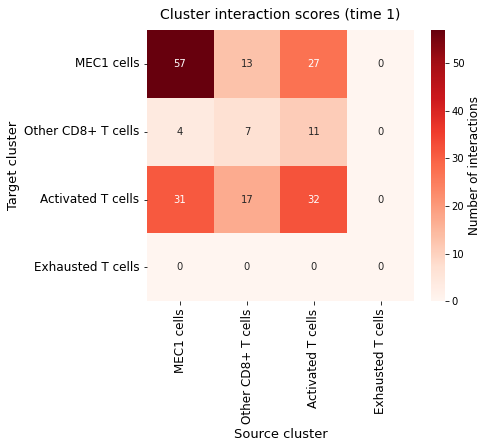

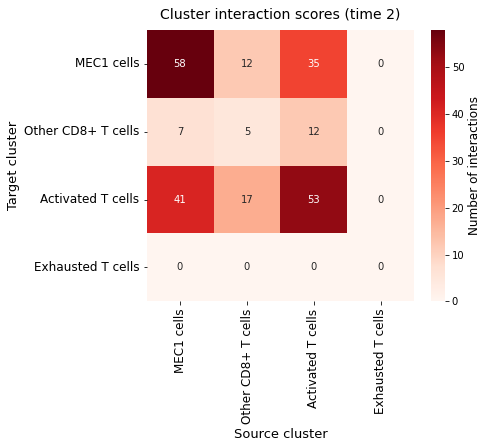

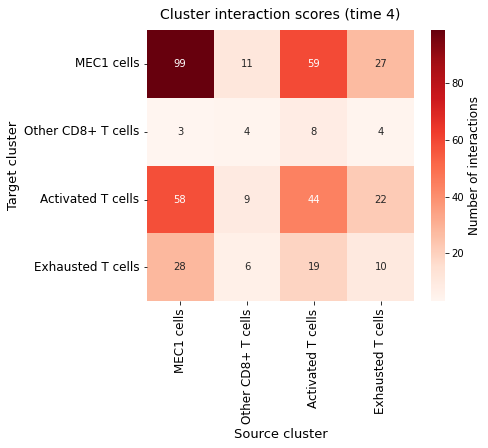

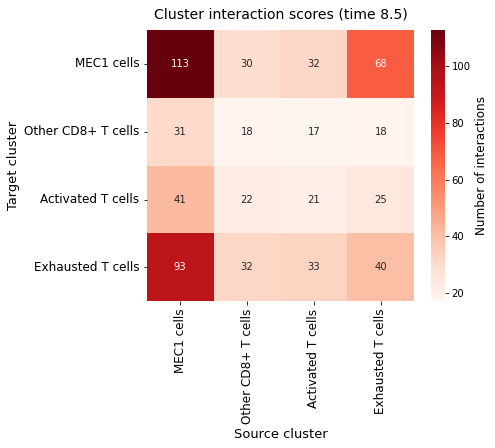

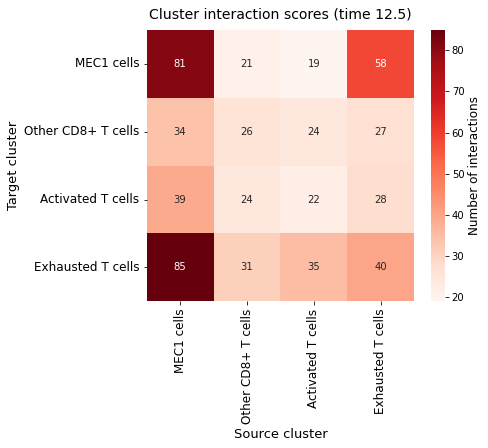

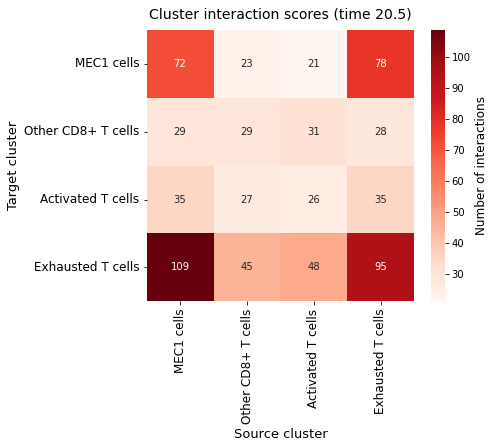

In [79]:
sample_cluster_interaction_score_matrices = {}

for timestamp in hours_post_coculture.values():
    cluster_interaction_score_matrix = create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, 
                                            rl_pairs, clusters_of_interest, sample_to_cluster_to_degs)
    sample_cluster_interaction_score_matrices[timestamp] = cluster_interaction_score_matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cluster_interaction_score_matrix, cmap="Reds", annot=True, fmt='.0f', 
                     cbar_kws={'label': 'Number of interactions'})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
    ax.set_xticklabels(clusters_of_interest, rotation=90, fontsize=12)
    plt.xlabel('Source cluster', fontsize=13)
    plt.ylabel('Target cluster', fontsize=13)
    plt.title(f'Cluster interaction scores (time {timestamp})', fontsize=14, y=1.02)

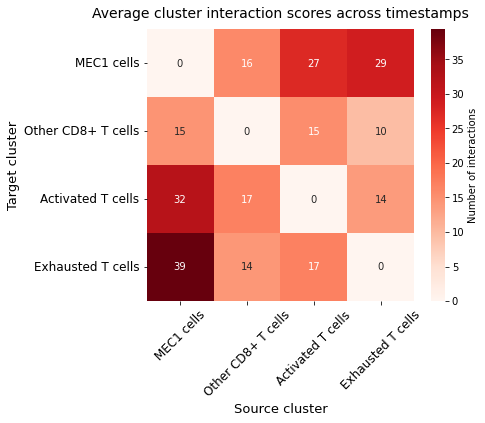

In [110]:
avg_cluster_interaction_score = np.nanmean(
    np.array(list(sample_cluster_interaction_score_matrices.values())), 
    axis=0)
np.fill_diagonal(avg_cluster_interaction_score, 0)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(avg_cluster_interaction_score, cmap="Reds", 
                 annot=True, fmt='.0f', cbar_kws={'label': 'Number of interactions'})
ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_of_interest, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Average cluster interaction scores across timestamps', fontsize=14, y=1.02)
plt.savefig('figures/CAR-T/interaction_scores.eps', bbox_inches="tight")

Text(0.5, 1.0, 'Distribution of average interaction scores')

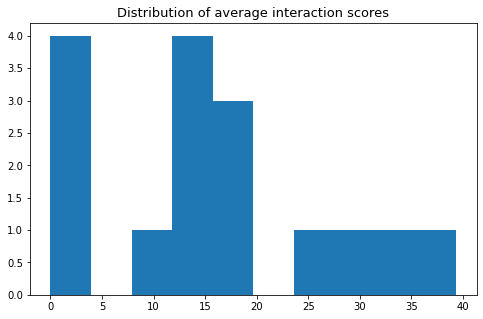

In [111]:
plt.figure(figsize=(8, 5))
plt.hist(avg_cluster_interaction_score.flatten(), bins=10)
plt.title('Distribution of average interaction scores', fontsize=13)

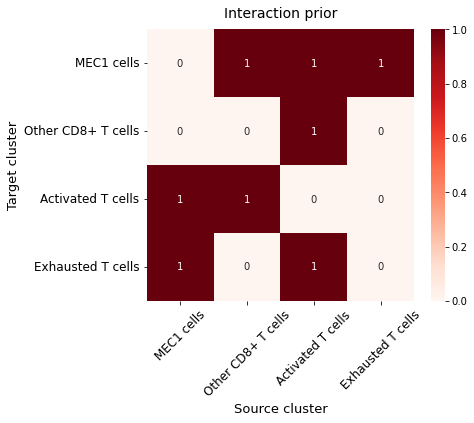

In [112]:
interaction_prior = avg_cluster_interaction_score >= 15

plt.figure(figsize=(6, 5))
ax = sns.heatmap(interaction_prior, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_of_interest, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Interaction prior', fontsize=14, y=1.02)
plt.savefig('figures/CAR-T/interaction_prior.eps', bbox_inches="tight")

In [113]:
np.save('data/CAR-T/interaction_prior.npy', interaction_prior)